In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('..')


In [3]:
data = pd.read_pickle('irr_df_20210622_20240618.pkl')
source = pd.read_pickle('trainval_df.pkl')


In [4]:
data

,KZPR_IRHoSunP,solpark_albedo_downwell_irr,MIS_IRHoSunP
date_time,,,
2021-06-22 13:00:00,NaN,NaN,482.6
2021-06-22 14:00:00,NaN,NaN,NaN
2021-06-22 15:00:00,NaN,NaN,NaN
2021-06-22 16:00:00,NaN,NaN,NaN
2021-06-22 17:00:00,NaN,NaN,NaN
...,...,...,...
2024-06-17 20:00:00,170.0,174.0,151.7
2024-06-17 21:00:00,65.0,67.0,34.3
2024-06-17 22:00:00,-3.0,-1.0,1.7


In [ ]:



def process_solar_irradiance(df, timestamp_col='date_time'):
    """

    """
    # Create a copy of the dataframe to avoid modifying the original
    processed_df = df.copy()
    
    # Columns for sensors
    sensor_columns = ['KZPR_IRHoSunP', 'solpark_albedo_downwell_irr', 'MIS_IRHoSunP']
    
    def fill_nans(group):
        # First, try to fill NaNs from other sensors
        for col in sensor_columns:
            group[col] = group.fillna(group[sensor_columns].drop(columns=[col]).mean())[col]
        
        return group
    def interpolate_nans_and_calculate_variance(group, window_hours=24, window_days=30):
        group = group.interpolate("time") # basically a linear interpolation as time steps are regular
        
        # Calculate variances for 24-hour and 30-day windows
        # Use the mean of sensor columns
        #mean_sensor_col = 'mean_sensor_irradiance'
        #group[mean_sensor_col] = group[sensor_columns].mean(axis=1)
        
        # 24-hour variance
        last_24h_data = group.rolling(window=f'{window_hours}H', min_periods=1).agg(['var', 'mean']) 
        group['last_24h_variance'] = last_24h_data["KZPR_IRHoSunP"]["var"]
        group['last_24h_mean'] = last_24h_data["KZPR_IRHoSunP"]['mean']
        
        # 30-day variance 
        last_30d_data = group.rolling(window=f'{window_days}D', min_periods=1).agg(['var', 'mean']) 
        group['last_30d_variance'] = last_30d_data["KZPR_IRHoSunP"]['var']
        group['last_30d_mean'] = last_30d_data["KZPR_IRHoSunP"]['mean']
        

        return group
    
    # Set timestamp as index if not already
    if timestamp_col not in processed_df.index.names:
        processed_df = processed_df.set_index(timestamp_col)
    
    # Sort index to ensure correct rolling window calculations
    processed_df = processed_df.sort_index()
    
    # Apply processing
    processed_df = processed_df.apply(fill_nans, axis = 1)
    processed_df = processed_df.drop(columns=['solpark_albedo_downwell_irr', 'MIS_IRHoSunP'])
    processed_df = interpolate_nans_and_calculate_variance(processed_df)
    
    return processed_df

# Example usage
processed_data = process_solar_irradiance(data).shift(1) # shift by 1 because we want the past

In [44]:
def interpolate_variance_columns(main_df, variance_df):
    """
    """
        # Ensure timezone consistency
    main_df = main_df.tz_localize(None) if main_df.index.tz is not None else main_df
    variance_df = variance_df.tz_localize(None) if variance_df.index.tz is not None else variance_df
    
    # Select only variance-related columns
    variance_cols = [col for col in variance_df.columns if 'variance' in col or 'mean' in col]
    
    # Interpolation function using numpy
    def interpolate_column(column):
        return np.interp(
            main_df.index.astype(np.int64), 
            variance_df.index.astype(np.int64), 
            column.values
        )
    
    # Interpolate each variance column
    interpolated_data = {}
    for col in variance_cols:
        interpolated_data[col] = interpolate_column(variance_df[col])
    
    # Create a DataFrame with interpolated values
    interpolated_df = pd.DataFrame(
        interpolated_data, 
        index=main_df.index
    )
    
    # Merge with main dataset
    result_df = pd.concat([main_df, interpolated_df], axis=1)
    
    return result_df

# Example usage
result = interpolate_variance_columns(source, processed_data)

<Axes: >

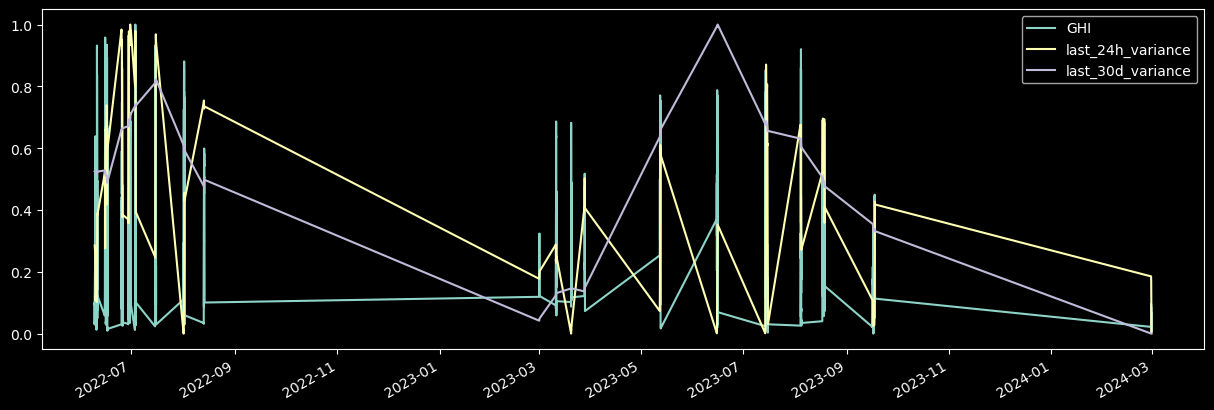

In [48]:

#result[['last_24h_variance', 'last_30d_variance']] = result[['last_24h_variance', 'last_30d_variance']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
result['GHI'] = (result['GHI'] - result['GHI'].min()) / (result['GHI'].max() - result['GHI'].min())
result.plot(y=['GHI', 'last_24h_variance', 'last_30d_variance'], figsize=(15, 5))

In [43]:
source

,CBH,CSa,CSb,Vxa,Vxb,Vya,Vyb,GHI,TOD,TOY,zenith,azimuth,GHI_clear
2022-06-09 05:52:10+02:00,1455.999878,0.6506,0.6601,-0.382812,-0.339842,0.443253,0.562887,40.999981,0.244560,0.438356,79.967601,61.029299,100.000933
2022-06-09 05:52:20+02:00,1557.000122,0.6442,0.6721,-0.391513,-0.329236,0.443950,0.548980,40.999981,0.244676,0.438356,79.949350,61.063576,100.310730
2022-06-09 05:52:30+02:00,1657.000122,0.6412,0.6870,-0.397475,-0.306498,0.445338,0.544455,40.999981,0.244792,0.438356,79.931094,61.097853,100.620837
2022-06-09 05:52:40+02:00,1606.999878,0.6460,0.6993,-0.408119,-0.306280,0.458668,0.544039,40.999981,0.244907,0.438356,79.912831,61.132127,100.931250
2022-06-09 05:52:50+02:00,1757.999878,0.6467,0.7163,-0.401098,-0.305662,0.452874,0.532619,40.999981,0.245023,0.438356,79.894563,61.166401,101.241970
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 16:05:10+01:00,2815.000000,0.7694,0.6109,-0.008113,-0.037187,0.029306,0.116311,7.999988,0.670255,0.164384,79.929215,234.785864,128.231875
2024-02-29 16:05:20+01:00,3017.000000,0.7828,0.5913,-0.004238,-0.175731,0.026017,-0.028389,7.999988,0.670370,0.164384,79.946216,234.824095,127.902034
2024-02-29 16:05:30+01:00,2765.000000,0.7729,0.6037,-0.003181,0.020822,0.030947,0.020839,7.999988,0.670486,0.164384,79.963225,234.862321,127.572172
2024-02-29 16:05:40+01:00,3016.000000,0.7628,0.5911,-0.000276,0.020822,0.024339,0.020839,7.999988,0.670602,0.164384,79.980242,234.900541,127.242289


In [6]:
# Ensure needed_time is truncated to match the index of data
truncated_time = needed_time.intersection(data.index)
data.loc[truncated_time, "KZPR_IRHoSunP"]

Series([], Freq: H, Name: KZPR_IRHoSunP, dtype: float64)

In [7]:
# Ensure both indices are sorted and have the same timezone
data_sorted = data.sort_index()
source_sorted = source.sort_index()

# Localize indices to UTC before converting to CET
data_sorted.index = data_sorted.index.tz_localize('UTC').tz_convert('CET')
source_sorted.index = source_sorted.index.tz_convert('CET')

# Perform the merge_asof operation
nearest_matches = pd.merge_asof(source_sorted, data_sorted, left_index=True, right_index=True, direction='nearest')

# Display the result
nearest_matches

,CBH,CSa,CSb,Vxa,Vxb,Vya,Vyb,GHI,TOD,TOY,zenith,azimuth,GHI_clear,KZPR_IRHoSunP,solpark_albedo_downwell_irr,MIS_IRHoSunP
2022-06-09 05:52:10+02:00,1455.999878,0.6506,0.6601,-0.382812,-0.339842,0.443253,0.562887,40.999981,0.244560,0.438356,79.967601,61.029299,100.000933,0.0,NaN,3.3
2022-06-09 05:52:20+02:00,1557.000122,0.6442,0.6721,-0.391513,-0.329236,0.443950,0.548980,40.999981,0.244676,0.438356,79.949350,61.063576,100.310730,0.0,NaN,3.3
2022-06-09 05:52:30+02:00,1657.000122,0.6412,0.6870,-0.397475,-0.306498,0.445338,0.544455,40.999981,0.244792,0.438356,79.931094,61.097853,100.620837,0.0,NaN,3.3
2022-06-09 05:52:40+02:00,1606.999878,0.6460,0.6993,-0.408119,-0.306280,0.458668,0.544039,40.999981,0.244907,0.438356,79.912831,61.132127,100.931250,0.0,NaN,3.3
2022-06-09 05:52:50+02:00,1757.999878,0.6467,0.7163,-0.401098,-0.305662,0.452874,0.532619,40.999981,0.245023,0.438356,79.894563,61.166401,101.241970,0.0,NaN,3.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 16:05:10+01:00,2815.000000,0.7694,0.6109,-0.008113,-0.037187,0.029306,0.116311,7.999988,0.670255,0.164384,79.929215,234.785864,128.231875,16.0,19.0,19.6
2024-02-29 16:05:20+01:00,3017.000000,0.7828,0.5913,-0.004238,-0.175731,0.026017,-0.028389,7.999988,0.670370,0.164384,79.946216,234.824095,127.902034,16.0,19.0,19.6
2024-02-29 16:05:30+01:00,2765.000000,0.7729,0.6037,-0.003181,0.020822,0.030947,0.020839,7.999988,0.670486,0.164384,79.963225,234.862321,127.572172,16.0,19.0,19.6
2024-02-29 16:05:40+01:00,3016.000000,0.7628,0.5911,-0.000276,0.020822,0.024339,0.020839,7.999988,0.670602,0.164384,79.980242,234.900541,127.242289,16.0,19.0,19.6


In [8]:
# check for nan
nearest_matches.isna().sum()

CBH                                0
CSa                                0
CSb                                0
Vxa                                0
Vxb                                0
Vya                                0
Vyb                                0
GHI                                0
TOD                                0
TOY                                0
zenith                             0
azimuth                            0
GHI_clear                          0
KZPR_IRHoSunP                    519
solpark_albedo_downwell_irr    57898
MIS_IRHoSunP                     519
dtype: int64

In [9]:
# check nan overlap in KZPR_IRHoSunP and MIS_IRHoSunP
nan_counts = nearest_matches[["KZPR_IRHoSunP", "MIS_IRHoSunP"]].isna().sum()
print(nan_counts)
# are they the same?
same_nan_count = nearest_matches[nearest_matches["KZPR_IRHoSunP"].isna()]["MIS_IRHoSunP"].isna().sum()
print(same_nan_count)

nan_days = nearest_matches[nearest_matches["KZPR_IRHoSunP"].isna()].index.floor("D").unique()
# filter nan_days to include only those present in the index
nan_days = nan_days.intersection(nearest_matches.index.floor("D"))
nan_days
# plot only the days with nan

#nearest_matches.loc[nan_days, "KZPR_IRHoSunP"].plot()

KZPR_IRHoSunP    519
MIS_IRHoSunP     519
dtype: int64
519


DatetimeIndex(['2023-05-12 00:00:00+02:00', '2023-06-15 00:00:00+02:00'], dtype='datetime64[ns, CET]', freq=None)